In [143]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from astropy.modeling import models, fitting
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval, ManualInterval
import h5py 
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm
from juanfit import SpectrumFitSingle, gaussian
from specutils.utils.wcs_utils import vac_to_air, air_to_vac
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

In [14]:
red_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayRed2017aug21/"

In [2]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_red_1s_proto.h5", 'r') as hf:
    bias_dc_red_1s = hf['image'][:]


In [3]:

helium_im_collection = ImageFileCollection(red_path,
                            glob_include="HeliumrRedpoint01s_920*.fit")
helium_im_df = helium_im_collection.summary.to_pandas()

In [4]:
helium_image_cube = np.zeros((1040,1392,10))

for ii, row_ in helium_im_df.iterrows():
    helium_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

(300.0, 750.0)

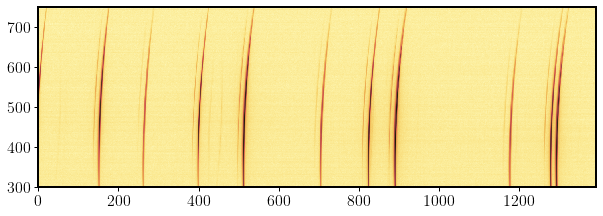

In [8]:
helium_im_aver = np.mean(helium_image_cube,axis=2)
yaxis_slice = slice(300,750)
norm = ImageNormalize(helium_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

(1285.0, 1300.0)

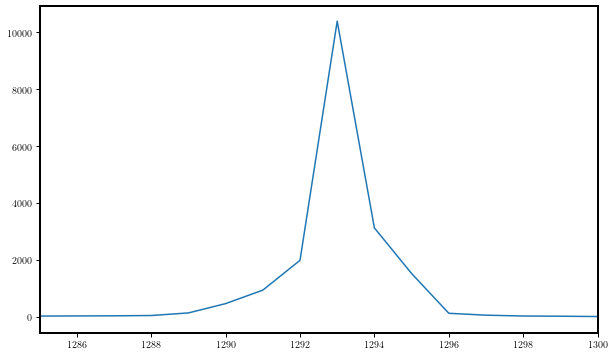

In [98]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(1392), np.mean(helium_im_aver[300:305,:],axis=0))
ax.set_xlim(1285,1300)

In [12]:
helium_im_aver.shape

(1040, 1392)

In [42]:
class TraceSingleCurvature:
    def __init__(self,image, init_start, init_end, xarray = None,ybin=5):
        self.nbins = int(image.shape[0]/ybin)
        self.xpos = np.zeros(self.nbins)
        self.xpos_err = np.zeros(self.nbins)
        if xarray is None:
            self.xarray = np.arange(image.shape[1])
        
        self.wvl_region_half_length = int(np.ceil((init_end - init_start)/2))
        first_bin_slice = slice(init_start,init_end)
        first_bin = np.mean(image[:ybin,first_bin_slice],axis=0)
        
        xpos_guess = init_start + np.argmax(first_bin)
        popt, pcov = curve_fit(gaussian_bg,xdata=self.xarray[first_bin_slice],ydata=first_bin, 
                    p0=[self.xarray[xpos_guess], first_bin[xpos_guess - first_bin_slice.start]*2, 2, 0])

        self.xpos[0] = popt[0]
        self.xpos_err[0] = np.sqrt(pcov[0,0])

        for ii in range(1,self.nbins):
            ii_slice = slice(int(np.rint(self.xpos[ii - 1]) - self.wvl_region_half_length),
                            int(np.rint(self.xpos[ii - 1]) + self.wvl_region_half_length))
            ii_bin = np.mean(image[int(ii*ybin):int((ii+1)*ybin),ii_slice],axis=0)
            xpos_guess = ii_slice.start + np.argmax(ii_bin)

            popt, pcov = curve_fit(gaussian_bg,xdata=self.xarray[ii_slice],ydata=ii_bin, 
                    p0=[self.xarray[xpos_guess], ii_bin[xpos_guess - ii_slice.start]*2, 2, 0])

            self.xpos[ii] = popt[0]
            self.xpos_err[ii] = np.sqrt(pcov[0,0])

        
def gaussian_bg(wvl, line_wvl, int_total, fwhm, bg):
    return gaussian(wvl, line_wvl=line_wvl, int_total=int_total, fwhm=fwhm) + bg




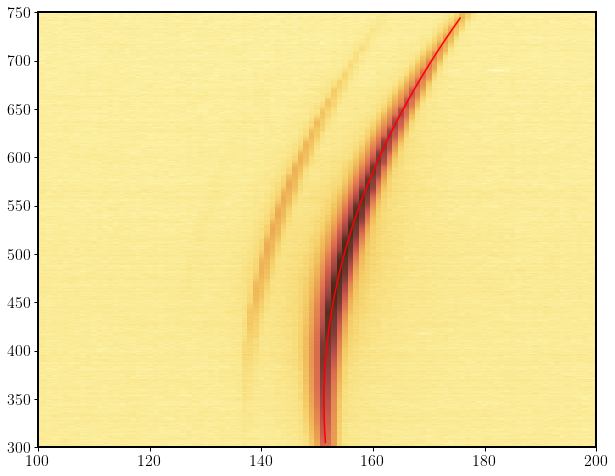

In [61]:
test_1 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=145,init_end=157)


fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_1_curve = test_1.xpos
test_1_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(100,200)

test_1_spl = UnivariateSpline(test_1_ypix, test_1_curve)
ax.plot(test_1_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [54]:
test_2 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=255,init_end=267)

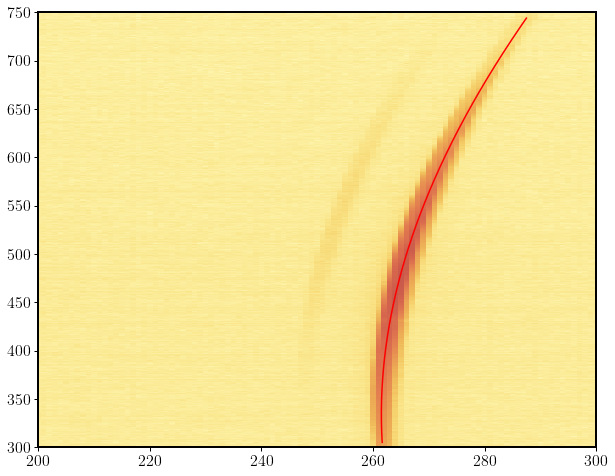

In [62]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_2_curve = test_2.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(200,300)

test_2_spl = UnivariateSpline(test_1_ypix, test_2_curve)
ax.plot(test_2_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [57]:
test_3 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=393,init_end=403)

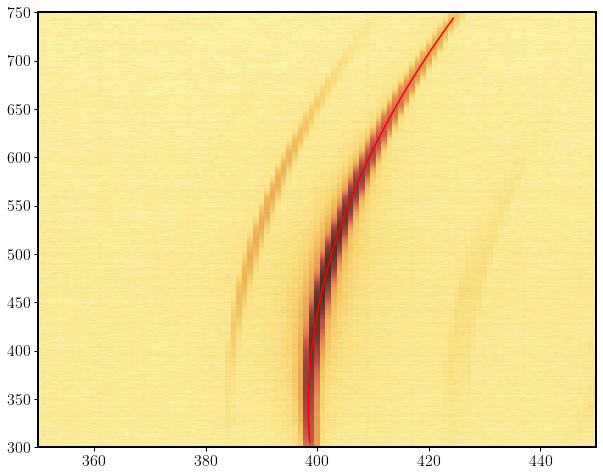

In [63]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_3_curve = test_3.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(350,450)

test_3_spl = UnivariateSpline(test_1_ypix, test_3_curve)
ax.plot(test_3_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [68]:
test_4 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=506,init_end=517)

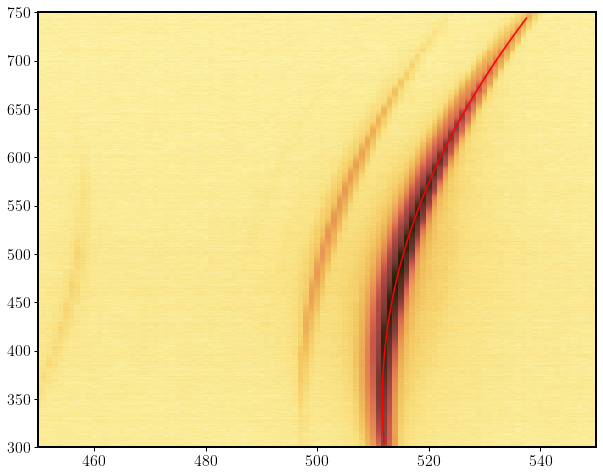

In [69]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_4_curve = test_4.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(450,550)

test_4_spl = UnivariateSpline(test_1_ypix, test_4_curve)
ax.plot(test_4_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [73]:
test_5 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=697,init_end=709)

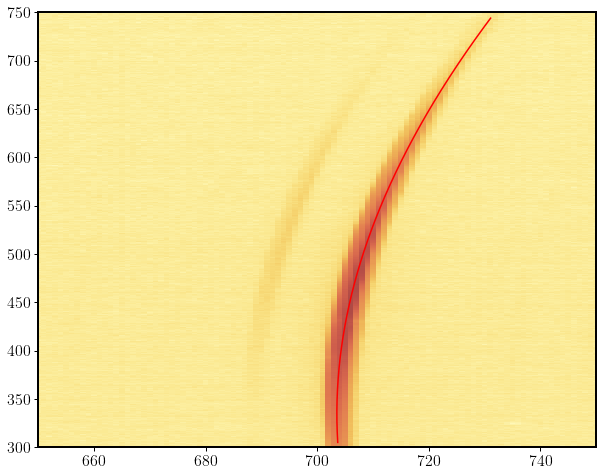

In [75]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_5_curve = test_5.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(650,750)

test_5_spl = UnivariateSpline(test_1_ypix, test_5_curve)
ax.plot(test_5_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [78]:
test_6 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=818,init_end=830)

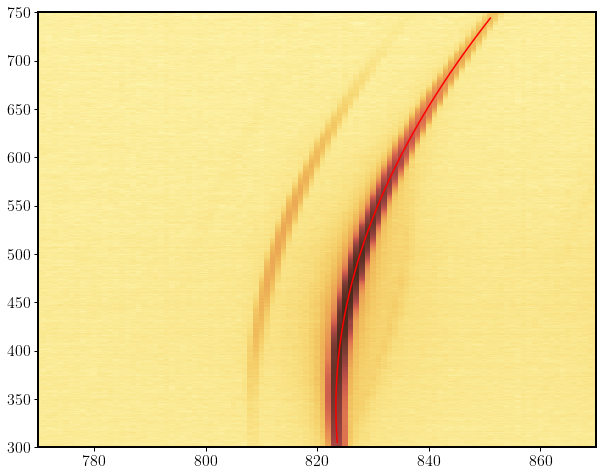

In [80]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_6_curve = test_6.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(770,870)

test_6_spl = UnivariateSpline(test_1_ypix, test_6_curve)
ax.plot(test_6_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [83]:
test_7 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=885,init_end=895)

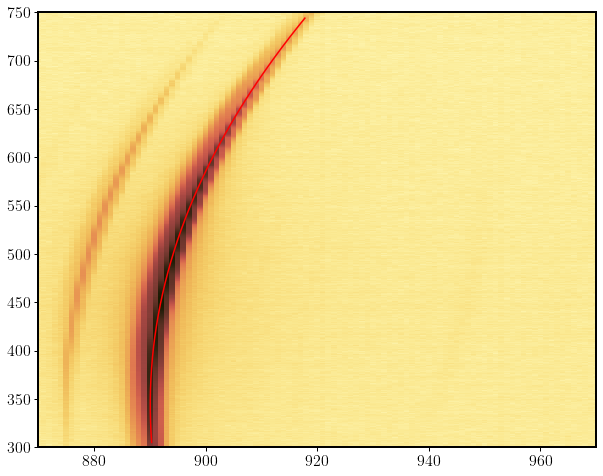

In [85]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_7_curve = test_7.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(870,970)

test_7_spl = UnivariateSpline(test_1_ypix, test_7_curve)
ax.plot(test_7_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [90]:
test_8 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1169,init_end=1184)

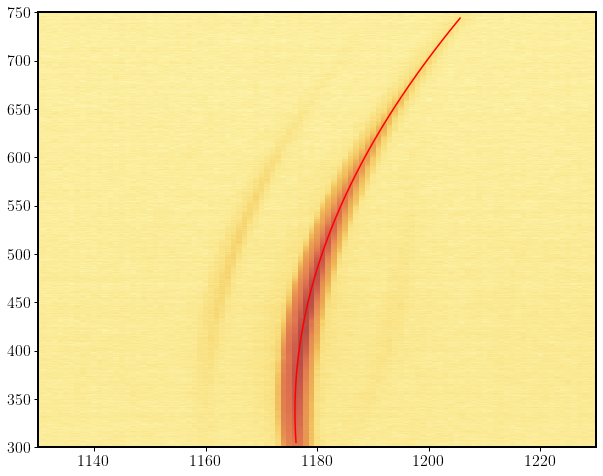

In [91]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_8_curve = test_8.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1130,1230)

test_8_spl = UnivariateSpline(test_1_ypix, test_8_curve)
ax.plot(test_8_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [95]:
test_9 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1270,init_end=1284)

In [99]:
test_10 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1285,init_end=1300)

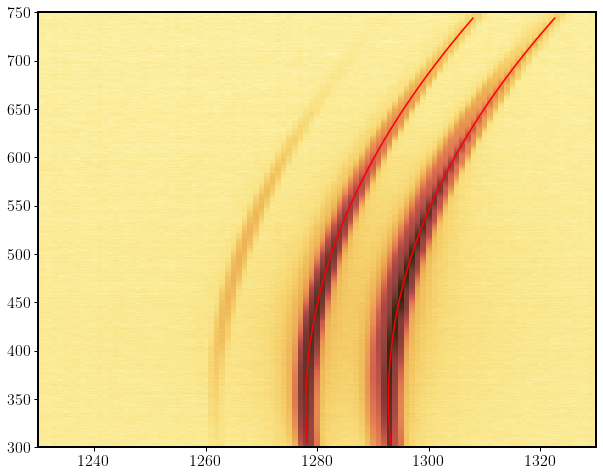

In [100]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_9_curve = test_9.xpos
test_10_curve = test_10.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1230,1330)

test_9_spl = UnivariateSpline(test_1_ypix, test_9_curve)
test_10_spl = UnivariateSpline(test_1_ypix, test_10_curve)
ax.plot(test_9_spl(np.arange(305,745)),np.arange(305,745),color="red")
ax.plot(test_10_spl(np.arange(305,745)),np.arange(305,745),color="red")

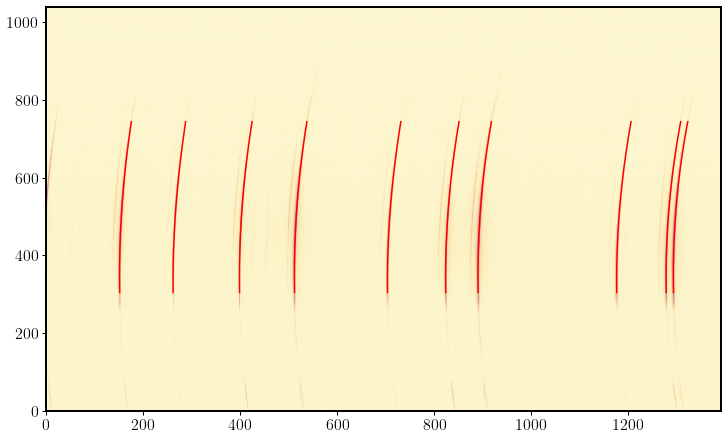

In [105]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.tick_params(labelsize=16)

spls = (test_1_spl,test_2_spl,test_3_spl,test_4_spl,test_5_spl,
            test_6_spl,test_7_spl,test_8_spl,test_9_spl,test_10_spl)
for spl_ in spls :
    ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="red")

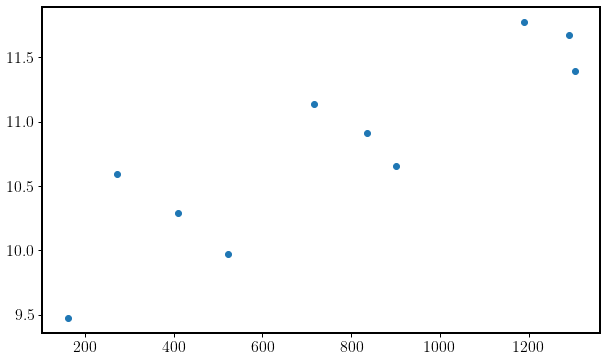

In [130]:
fig, ax = plt.subplots(figsize=(10,6))
xpos_y600 = np.array([spl_(600) for spl_ in spls])
xpos_y400 = np.array([spl_(400) for spl_ in spls])
xshift_y600 = xpos_y600 - xpos_y400
ax.scatter(xpos_y600, xshift_y600)
ax.tick_params(labelsize=16)

In [120]:
ypos_tofit = np.tile(np.arange(305,745),(10,1)).T
xpos_tofit = np.zeros_like(ypos_tofit)
for ii, spl_ in enumerate(spls):
    xpos_tofit[:,ii] = spl_(ypos_tofit[:,ii])
xshift_tofit = xpos_tofit - xpos_tofit[95,:]

In [123]:
chebyshev2d_init = models.Chebyshev2D(x_degree=6,y_degree=6)
fit_chebyshev2d = fitting.LevMarLSQFitter()
chebyshev2d_p = fit_chebyshev2d(chebyshev2d_init,xpos_tofit, ypos_tofit, xshift_tofit)

Text(0, 0.5, '')

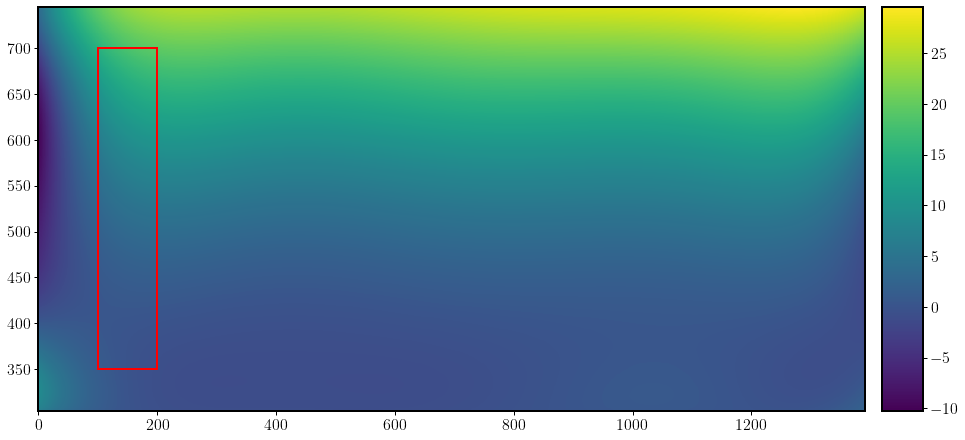

In [148]:
ypos_plot, xpos_plot = np.mgrid[305:745,:1392]
fig, ax = plt.subplots(figsize=(12,6),constrained_layout=True)
im = ax.pcolormesh(xpos_plot, ypos_plot, chebyshev2d_p(xpos_plot, ypos_plot),rasterized=True)

testx_slice = slice(100,200)
testy_slice = slice(350,700)

test_rectangle = Rectangle((testx_slice.start, testy_slice.start), 
                    testx_slice.stop - testx_slice.start,
                    testy_slice.stop - testy_slice.start,
                    edgecolor="red",facecolor='none',lw=2)

ax.add_patch(test_rectangle)

ax.tick_params(labelsize=16)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

In [149]:
class ChebyShevMappinig:
    def __init__(self,chebyshev_model):
        self.chebyshev_model = chebyshev_model

    def shift_func(self, output_coords):
        return (output_coords[0] - self.chebyshev_model(output_coords[0],output_coords[1]), output_coords[1])

In [170]:
def shift_func(output_coords):
    return (output_coords[0], 
            output_coords[1] + chebyshev2d_p(output_coords[1]+100,output_coords[0]+350))

In [171]:
helium_trans_test = ndimage.geometric_transform(helium_im_aver[testy_slice, testx_slice],shift_func)

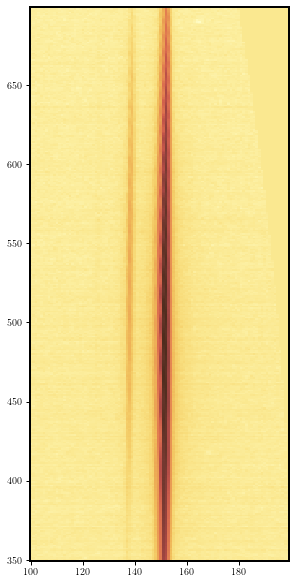

In [174]:
fig, ax = plt.subplots(figsize=(4,8),constrained_layout=True)
ax.pcolormesh(np.arange(testx_slice.start,testx_slice.stop),np.arange(testy_slice.start,testy_slice.stop),
            helium_trans_test,norm=norm,cmap=cmcm.lajolla,rasterized=True)

In [193]:
testx_slice_mapcoor = slice(100,1350)
testy_slice_mapcoor = slice(350,700)
ypos_map_coordinate, xpos_map_coordinate = np.mgrid[testy_slice_mapcoor,testx_slice_mapcoor]
xpos_map_coordinate = xpos_map_coordinate + chebyshev2d_p(xpos_map_coordinate, ypos_map_coordinate)

xpos_map_coordinate = xpos_map_coordinate - testx_slice_mapcoor.start
ypos_map_coordinate = ypos_map_coordinate - testy_slice_mapcoor.start


In [194]:
helium_trans_mapcoor = ndimage.map_coordinates(helium_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate))

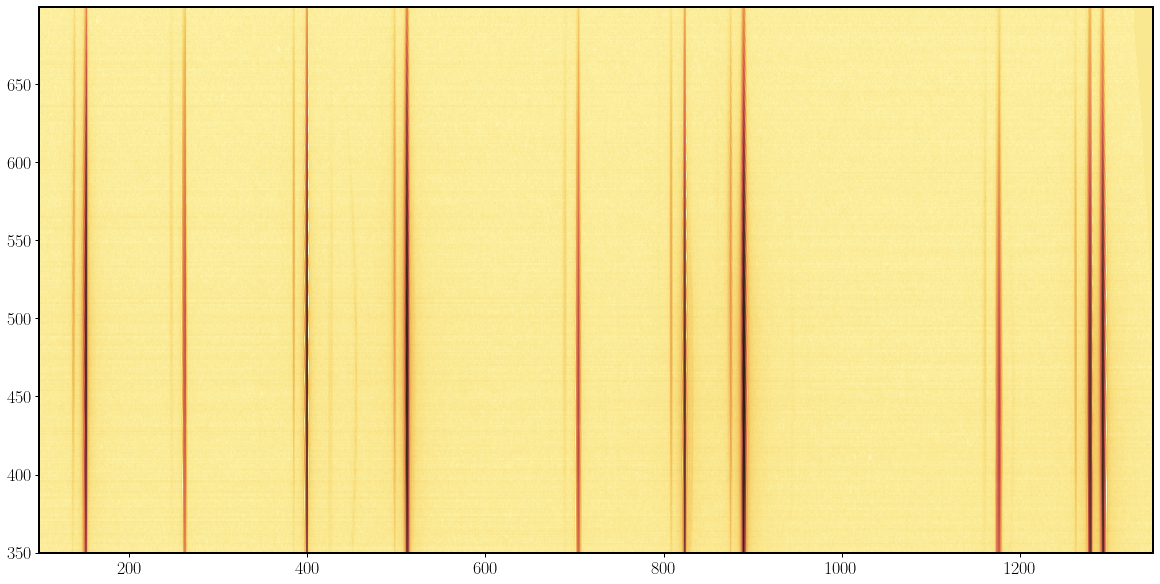

In [195]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            helium_trans_mapcoor,norm=norm,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)

In [196]:
mylar_im_collection = ImageFileCollection(red_path,
                            glob_include="SunMylarRedpoint1s_740*.fit")
mylar_im_df = mylar_im_collection.summary.to_pandas()

In [199]:
mylar_image_cube = np.zeros((1040,1392,10))

for ii, row_ in mylar_im_df.iterrows():
    mylar_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

mylar_im_aver = np.mean(mylar_image_cube,axis=2)

In [200]:
mylar_trans_mapcoor = ndimage.map_coordinates(mylar_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate))

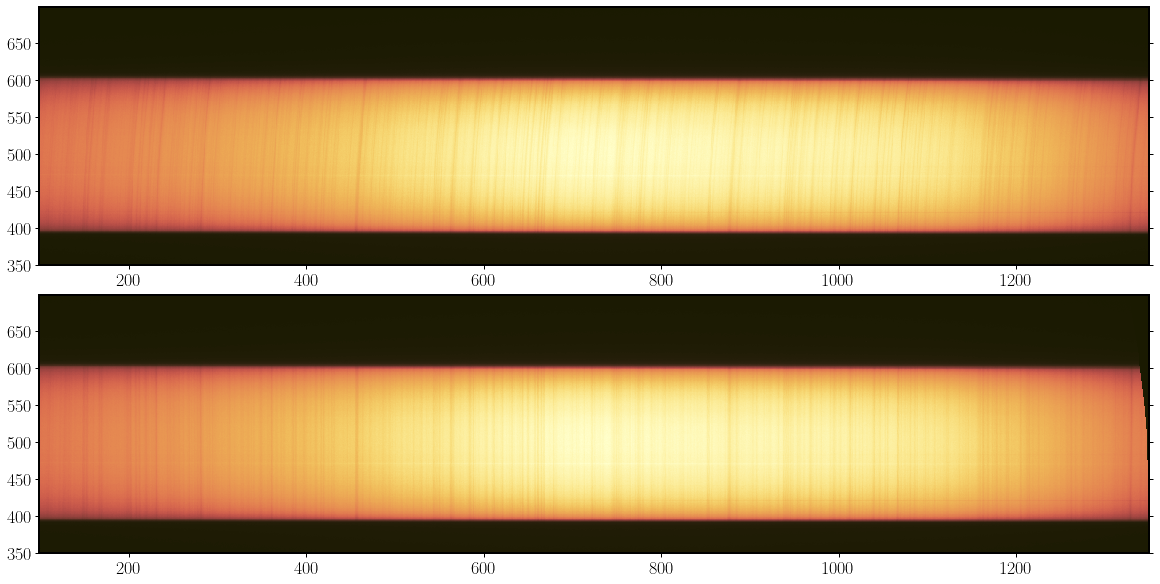

In [207]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla_r,rasterized=True)
ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_trans_mapcoor,cmap=cmcm.lajolla_r,rasterized=True)

for ax_ in (ax1,ax2):
    ax_.tick_params(labelsize=18,right=True)

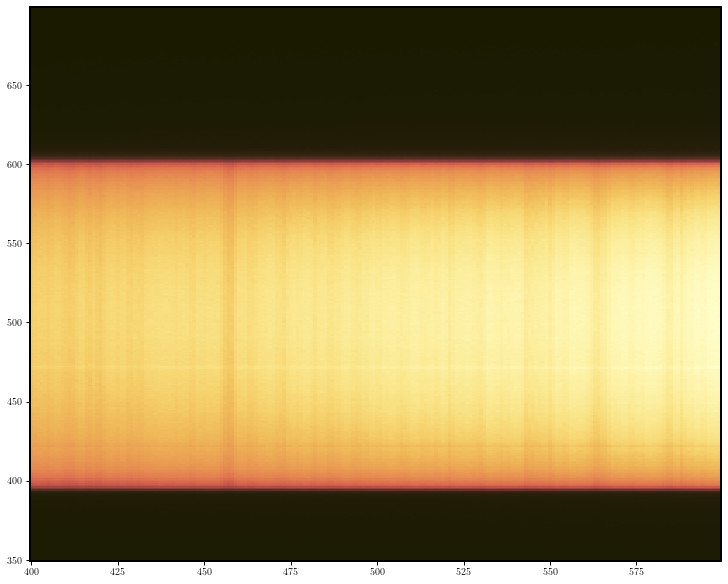

In [206]:
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
ax.pcolormesh(np.arange(400,600),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_trans_mapcoor[:,300:500],cmap=cmcm.lajolla_r,rasterized=True)